# Sentiment Analysis and Visualization
Note: The sentiment annotation program has to be run first

In [1]:
import csv
import pandas as pd
import seaborn as sns
from unsc_sentiment.corpus_utils import get_debates_by_theme
from config import META_PATH, SPEAKER_PATH, SENTENCE_ANNOTATIONS, SPEECH_ANNOTATIONS

## Analyse speeches with specific debate theme

### Extract debate ids
This example uses the WPS theme (Women, peace and security).\
Note: A theme might have multiple spellings/wordings, so synonyms are used as function input.

In [5]:
theme_synonyms = ["Women and peace and security", "Women, peace, and security"]
wps_debate_ids = get_debates_by_theme(theme_synonyms, META_PATH)
print(len(wps_debate_ids)) # Should be 66 for WPS

66


### Get sentiment of the debate speeches and save as csv

In [8]:
# Paths to the output sentiment csvs
wps_sentiment_per_sentence_csv = "data/unsc_wps_sentiment_per_sentence.csv"
wps_sentiment_per_speech_csv = "data/unsc_wps_sentiment_per_speech.csv"

In [9]:
# Function for checking if a speech is part of a WPS debate
def is_wps(speech_id, wps_ids):
    for sid in wps_ids:
        if sid in speech_id:
            return True
    return False

#### Create the sentence level output csv

In [30]:
wps_sentiment_ps_header = ["speech_id", "paragraphIndex", "paragraphSentenceIndex", "totalSentenceIndex", "sentimentScore"]
with open(wps_sentiment_per_sentence_csv, "w", encoding="utf-8") as wps_sentiment_ps_csv:
    wps_writer = csv.writer(wps_sentiment_ps_csv)
    wps_writer.writerow(wps_sentiment_ps_header)
    # Iterate the annotated UNSC speeches
    # If a speech belongs to the WPS debates copy entry to output file
    with open(SENTENCE_ANNOTATIONS, "r", encoding="utf-8") as unsc_sentiment_csv:
        unsc_reader = csv.reader(unsc_sentiment_csv, delimiter="\t")
        # skip header
        next(unsc_reader, None)
        for entry in unsc_reader:
            if is_wps(entry[0], wps_debate_ids):
                speech_id = entry[0].split("/")[-1][:-4]
                p_index = entry[1]
                ps_index = entry[2]
                ts_index = entry[2]
                score = entry[5]
                wps_writer.writerow([speech_id, p_index, ps_index, ts_index, score])
        unsc_sentiment_csv.close()
    wps_sentiment_ps_csv.close()

#### Create the speech level output csv

In [69]:
wps_sentiment_header = ["speech_id", "speechPath", "sentimentScore", "speech_annotation_path"]
with open(wps_sentiment_per_speech_csv, "w", encoding="utf-8") as wps_sentiment_csv:
    wps_writer = csv.writer(wps_sentiment_csv)
    wps_writer.writerow(wps_sentiment_header)
    # Iterate the annotated UNSC speeches
    # If a speech belongs to the WPS debates copy entry to output file
    with open(SPEECH_ANNOTATIONS, "r", encoding="utf-8") as unsc_sentiment_csv:
        unsc_reader = csv.reader(unsc_sentiment_csv, delimiter="\t")
        # skip header
        next(unsc_reader, None)
        for entry in unsc_reader:
            if is_wps(entry[0], wps_debate_ids):
                speech_id = entry[0]
                speech_path = entry[1]
                score = entry[2]
                annotation_path = entry[3]
                wps_writer.writerow([speech_id, speech_path, score, annotation_path])
        unsc_sentiment_csv.close()
    wps_sentiment_csv.close()

### Get meta data of the extracted speeches

In [37]:
# Path to the output meta data csv
wps_meta_csv = "data/wps_meta_for_analysis.csv"

In [38]:
# Create the output csv 
wps_meta_header = ["speech_id", "year", "month", "day", "country"]
with open(wps_meta_csv, "w", encoding="utf-8") as wps_metacsv:
    wps_writer = csv.writer(wps_metacsv)
    wps_writer.writerow(wps_meta_header)
    # Iterate the speaker meta data of the UNSC speeches
    # If a speech belongs to the WPS debates copy entry to output file
    with open(SPEAKER_PATH, "r", encoding="utf-8") as speakerfile:
        speaker_reader = csv.reader(speakerfile, delimiter="\t")
        for entry in speaker_reader:
            if is_wps(entry[12], wps_debate_ids):
                speech_id = entry[12][:-4]
                year = entry[9]
                month = entry[10]
                day = entry[11]
                country = entry[1]
                wps_writer.writerow([speech_id, year, month, day, country])
        speakerfile.close()
    wps_metacsv.close()

### Merge meta and sentiment data

#### Sentence level data

In [39]:
wps_only_sentiment_ps_df = pd.read_csv(wps_sentiment_per_sentence_csv)
wps_meta_df = pd.read_csv(wps_meta_csv)
wps_sentiment_ps_df = pd.merge(wps_only_sentiment_ps_df, wps_meta_df, on="speech_id")

In [40]:
wps_sentiment_ps_df.shape # Should be (77435, 5) for WPS

(77435, 9)

#### Speech level data

In [70]:
wps_only_sentiment_df = pd.read_csv(wps_sentiment_per_speech_csv)
wps_meta_df = pd.read_csv(wps_meta_csv)
wps_sentiment_df = pd.merge(wps_only_sentiment_df, wps_meta_df, on="speech_id")

In [72]:
wps_sentiment_df.shape # Should be (4011, 8) for WPS

(4011, 8)

### Visualize sentence level WPS sentiment over the years

In [34]:
sns.set_context("notebook", font_scale=2)  

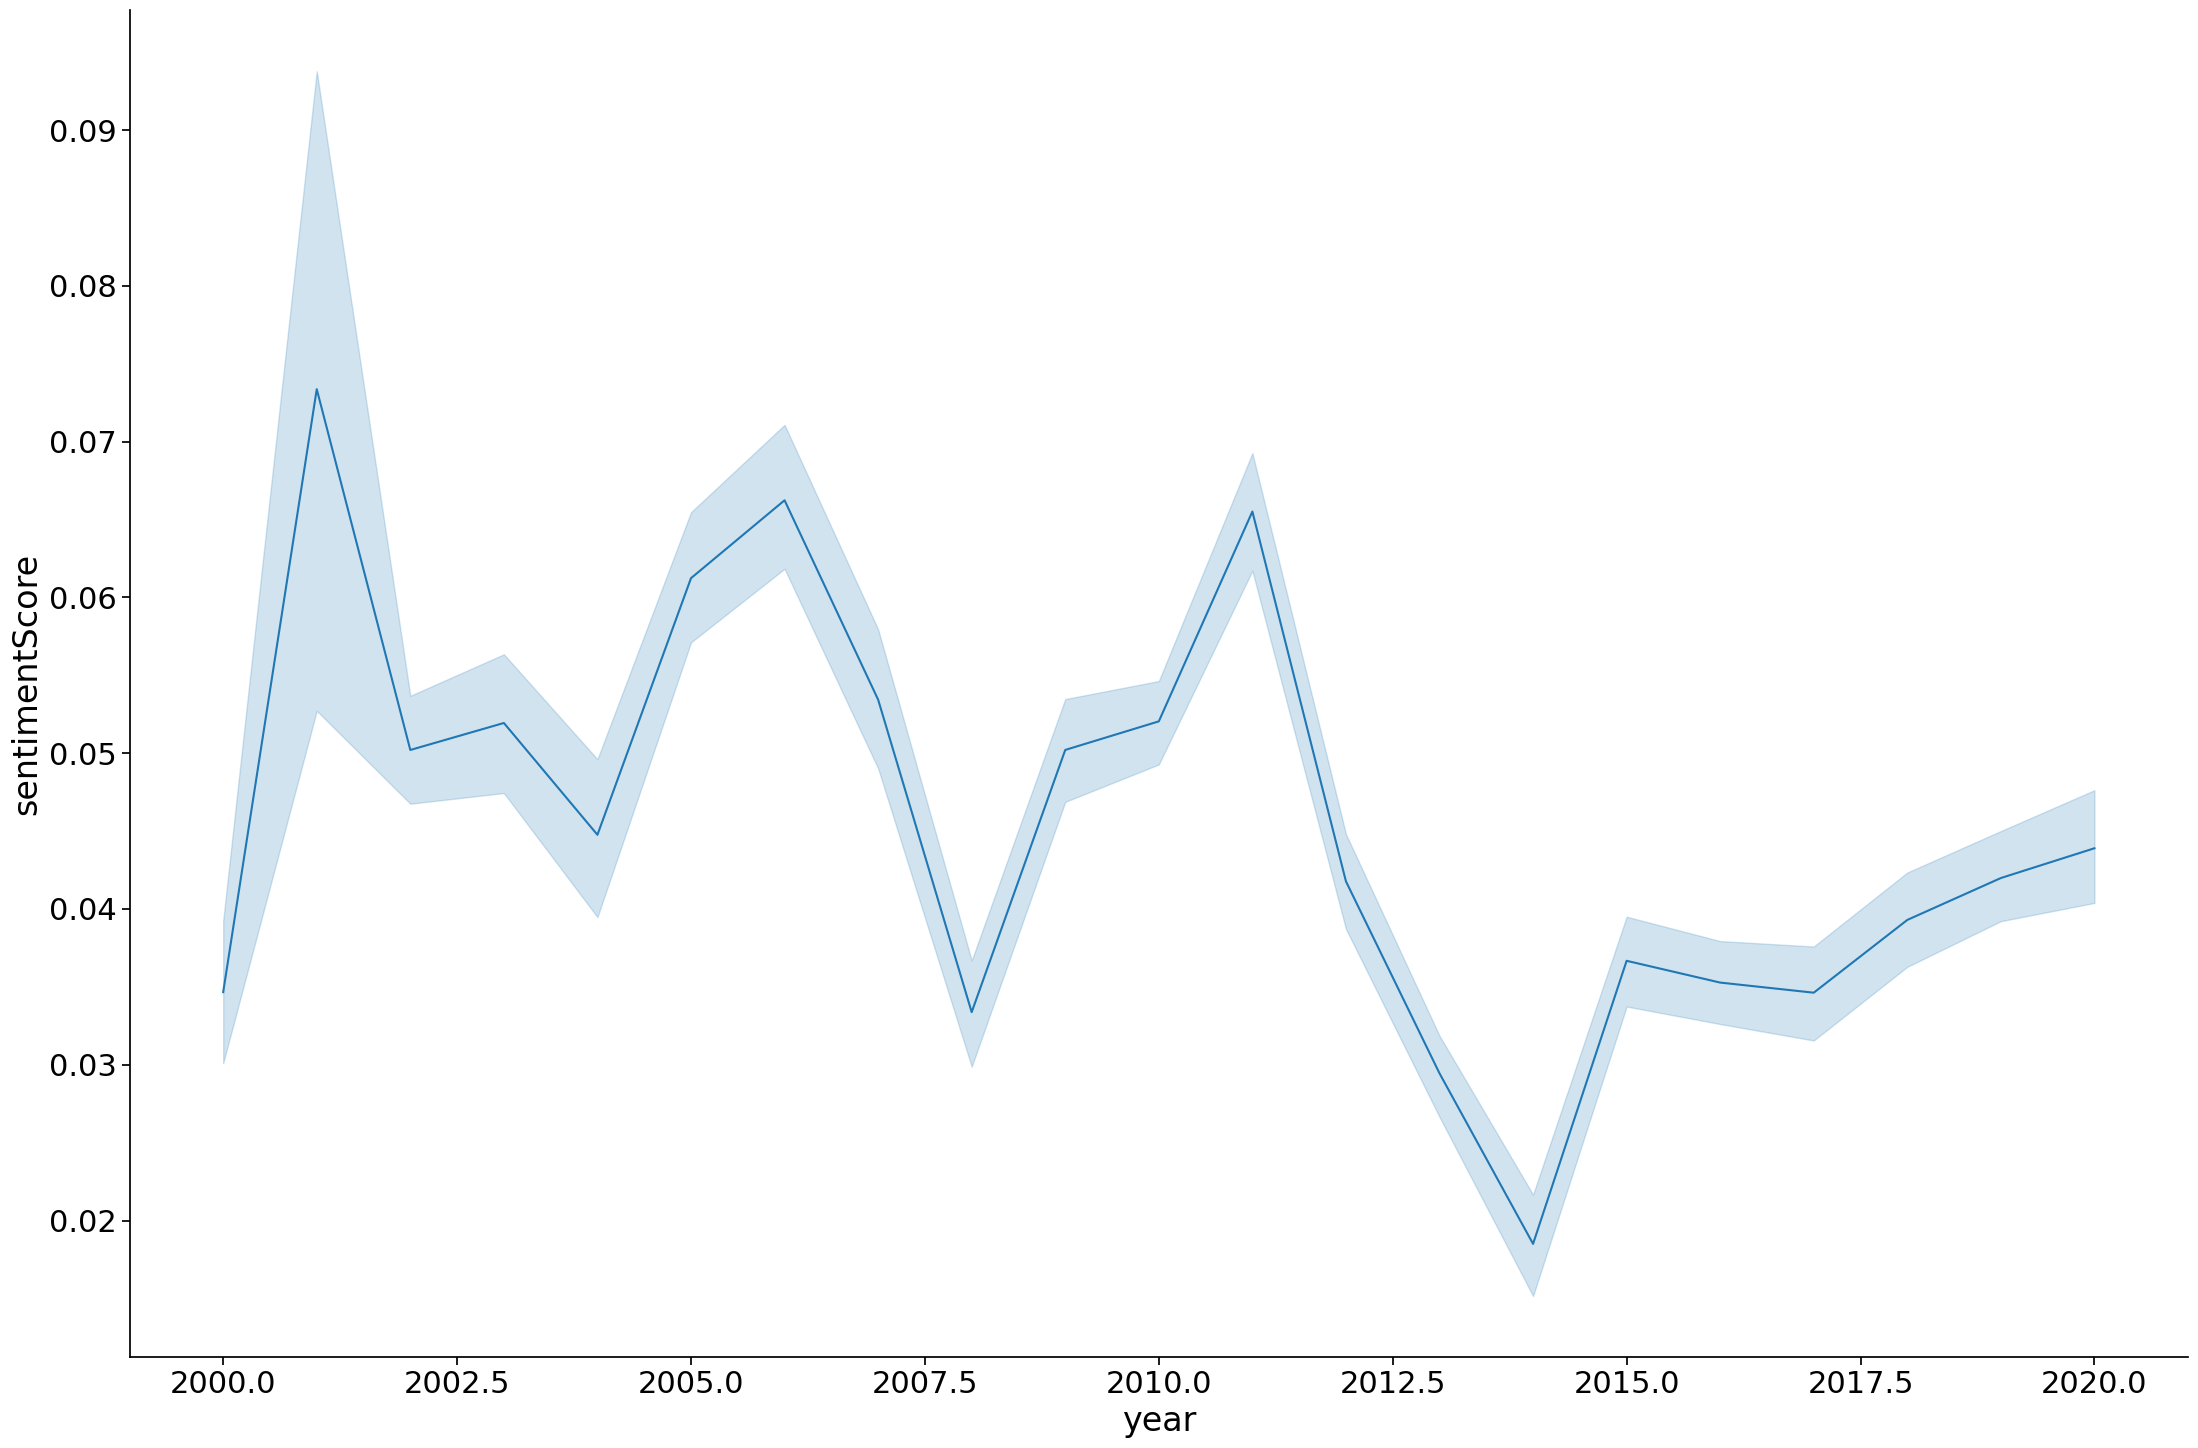

In [41]:
sns.relplot(x="year", y="sentimentScore", kind="line", data=wps_sentiment_ps_df, height=15, aspect=1.5)

### Visualize speech level WPS sentiment over the years


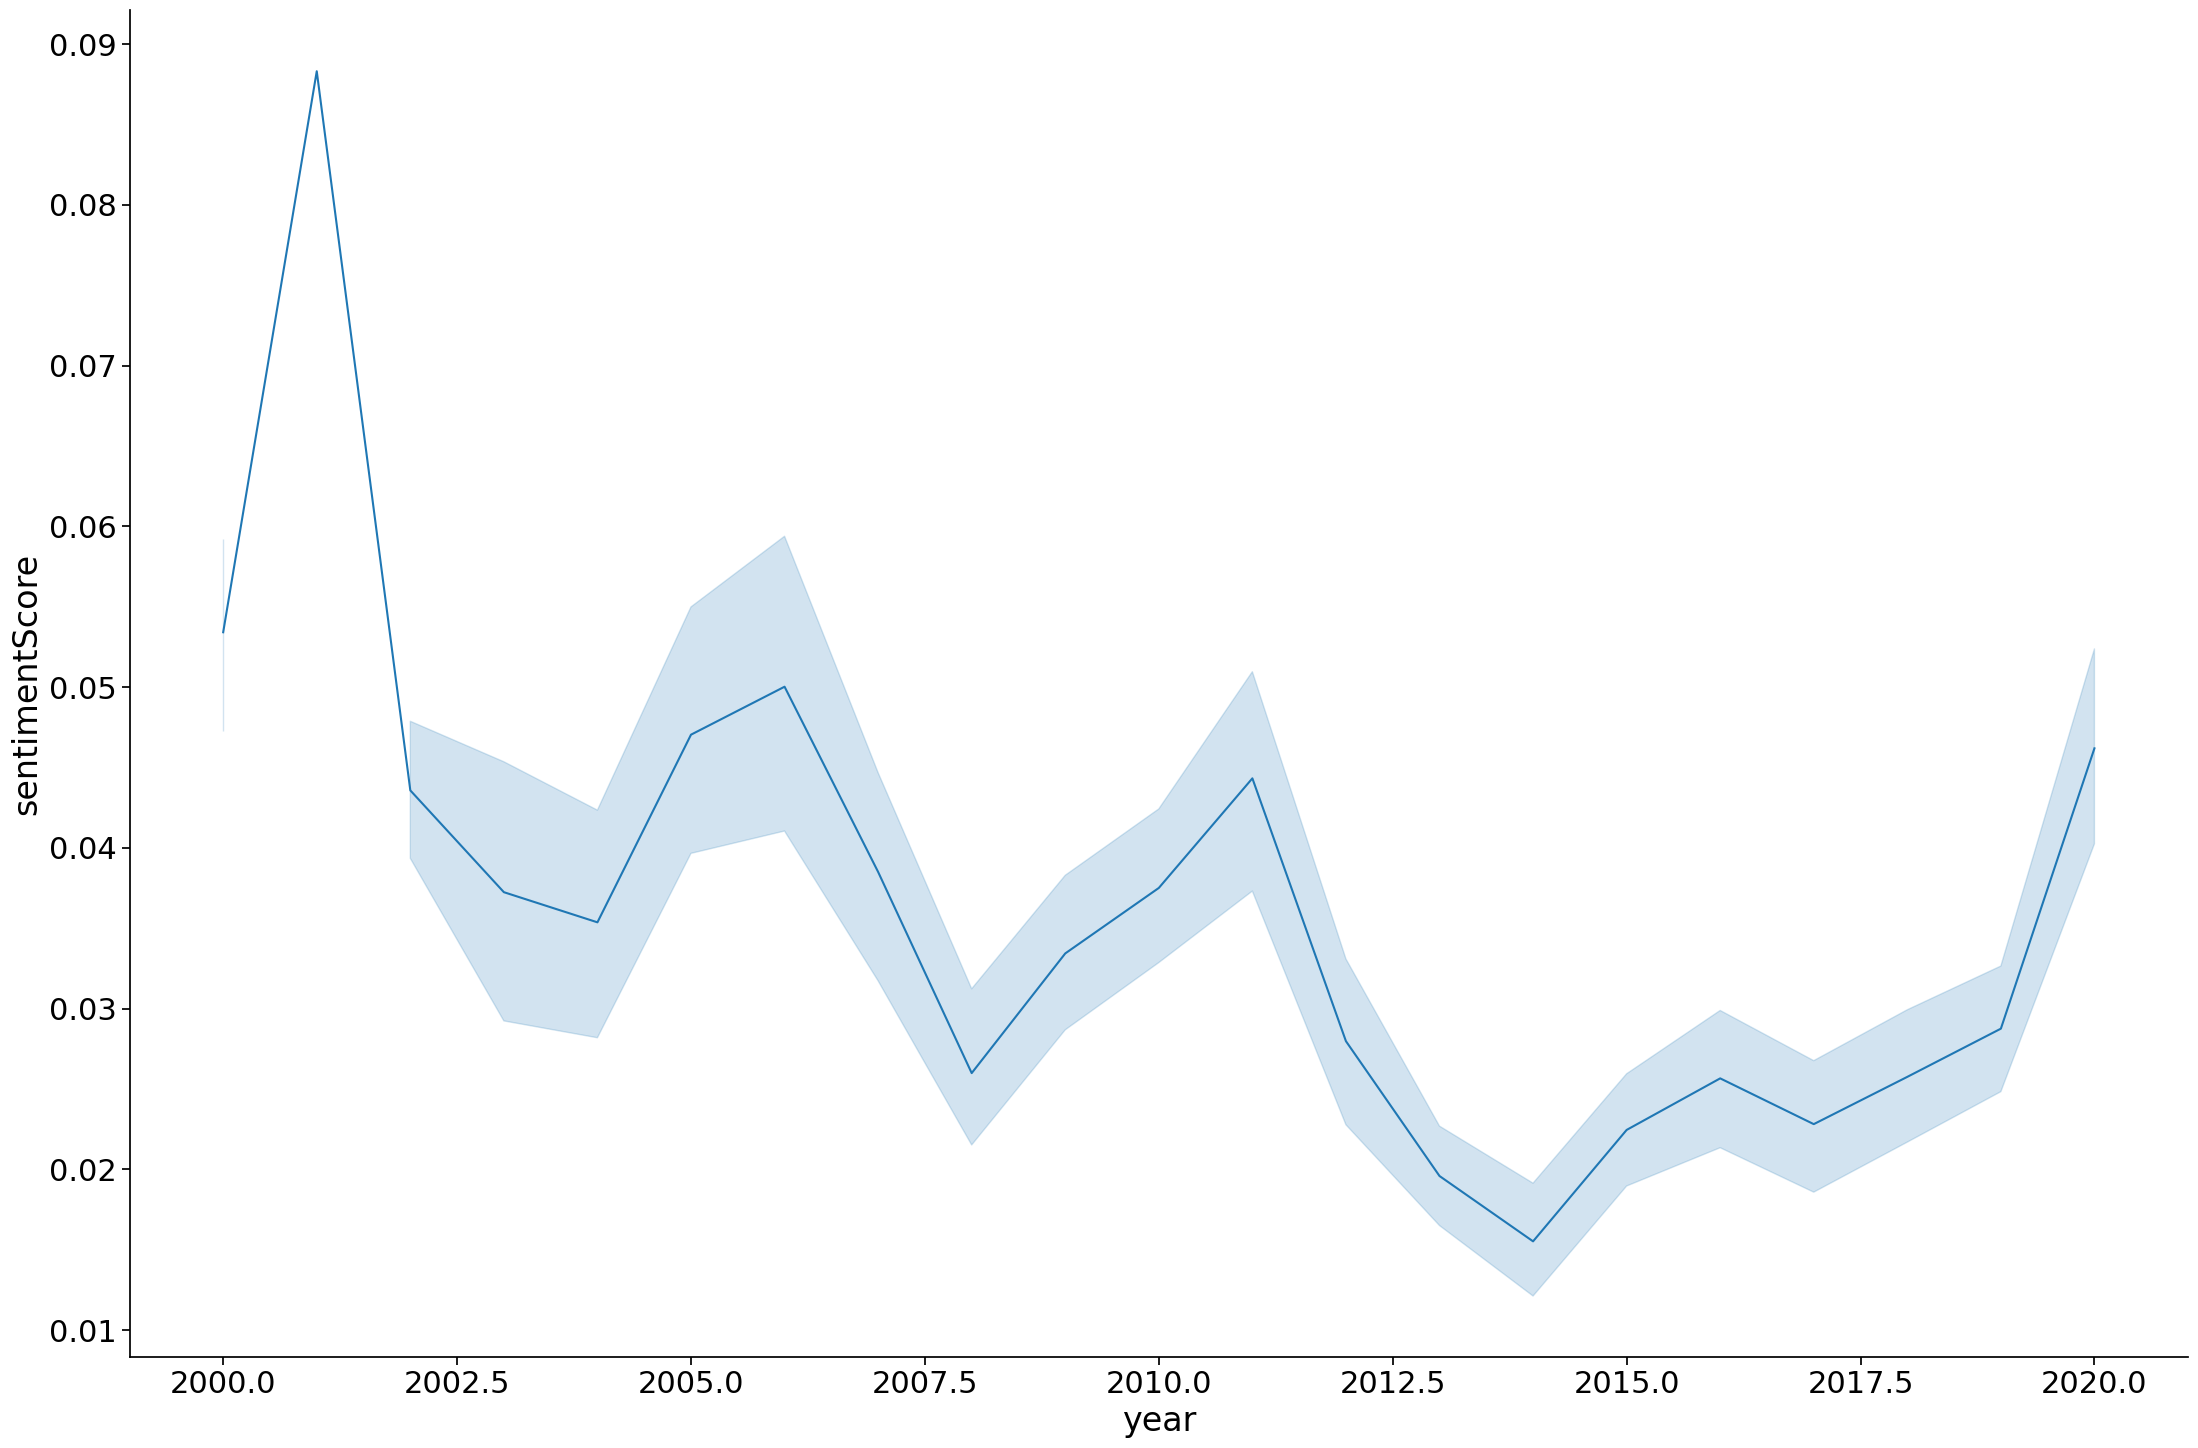

In [73]:
sns.relplot(x="year", y="sentimentScore", kind="line", data=wps_sentiment_df, height=15, aspect=1.5)

## Analyse P5 speeches

### Get meta data of all speeches

In [42]:
# Path to the output meta data csv
meta_csv = "data/unsc_meta_for_analysis.csv"

In [56]:
# Create the output csv 
meta_header = ["speech_id", "year", "month", "day", "country"]
with open(meta_csv, "w", encoding="utf-8") as metafile:
    meta_writer = csv.writer(metafile)
    meta_writer.writerow(meta_header)
    with open(SPEAKER_PATH, "r", encoding="utf-8") as speakerfile:
        speaker_reader = csv.reader(speakerfile, delimiter="\t")
        next(speaker_reader, None)
        for entry in speaker_reader:
            speech_id = entry[12][:-4]
            year = entry[9]
            month = entry[10]
            day = entry[11]
            country = entry[1]
            meta_writer.writerow([speech_id, year, month, day, country])
        speakerfile.close()
    metafile.close()

### Merge meta and sentiment data


In [57]:
meta_df = pd.read_csv(meta_csv)
only_sentiment_df = pd.read_csv(SPEECH_ANNOTATIONS, sep="\t")
sentiment_df = pd.merge(only_sentiment_df, meta_df, on="speech_id")

In [58]:
sentiment_df.shape # Should be (82165, 8) for WPS

(82165, 8)

### Analyse sentiment of P5 speeches


In [63]:
# Names of the 5 permanent members 
p5 = ["China", "France", "Russian Federation", "United Kingdom Of Great Britain And Northern Ireland", "United States Of America"]
p5_df = sentiment_df[sentiment_df["country"].isin(p5)]

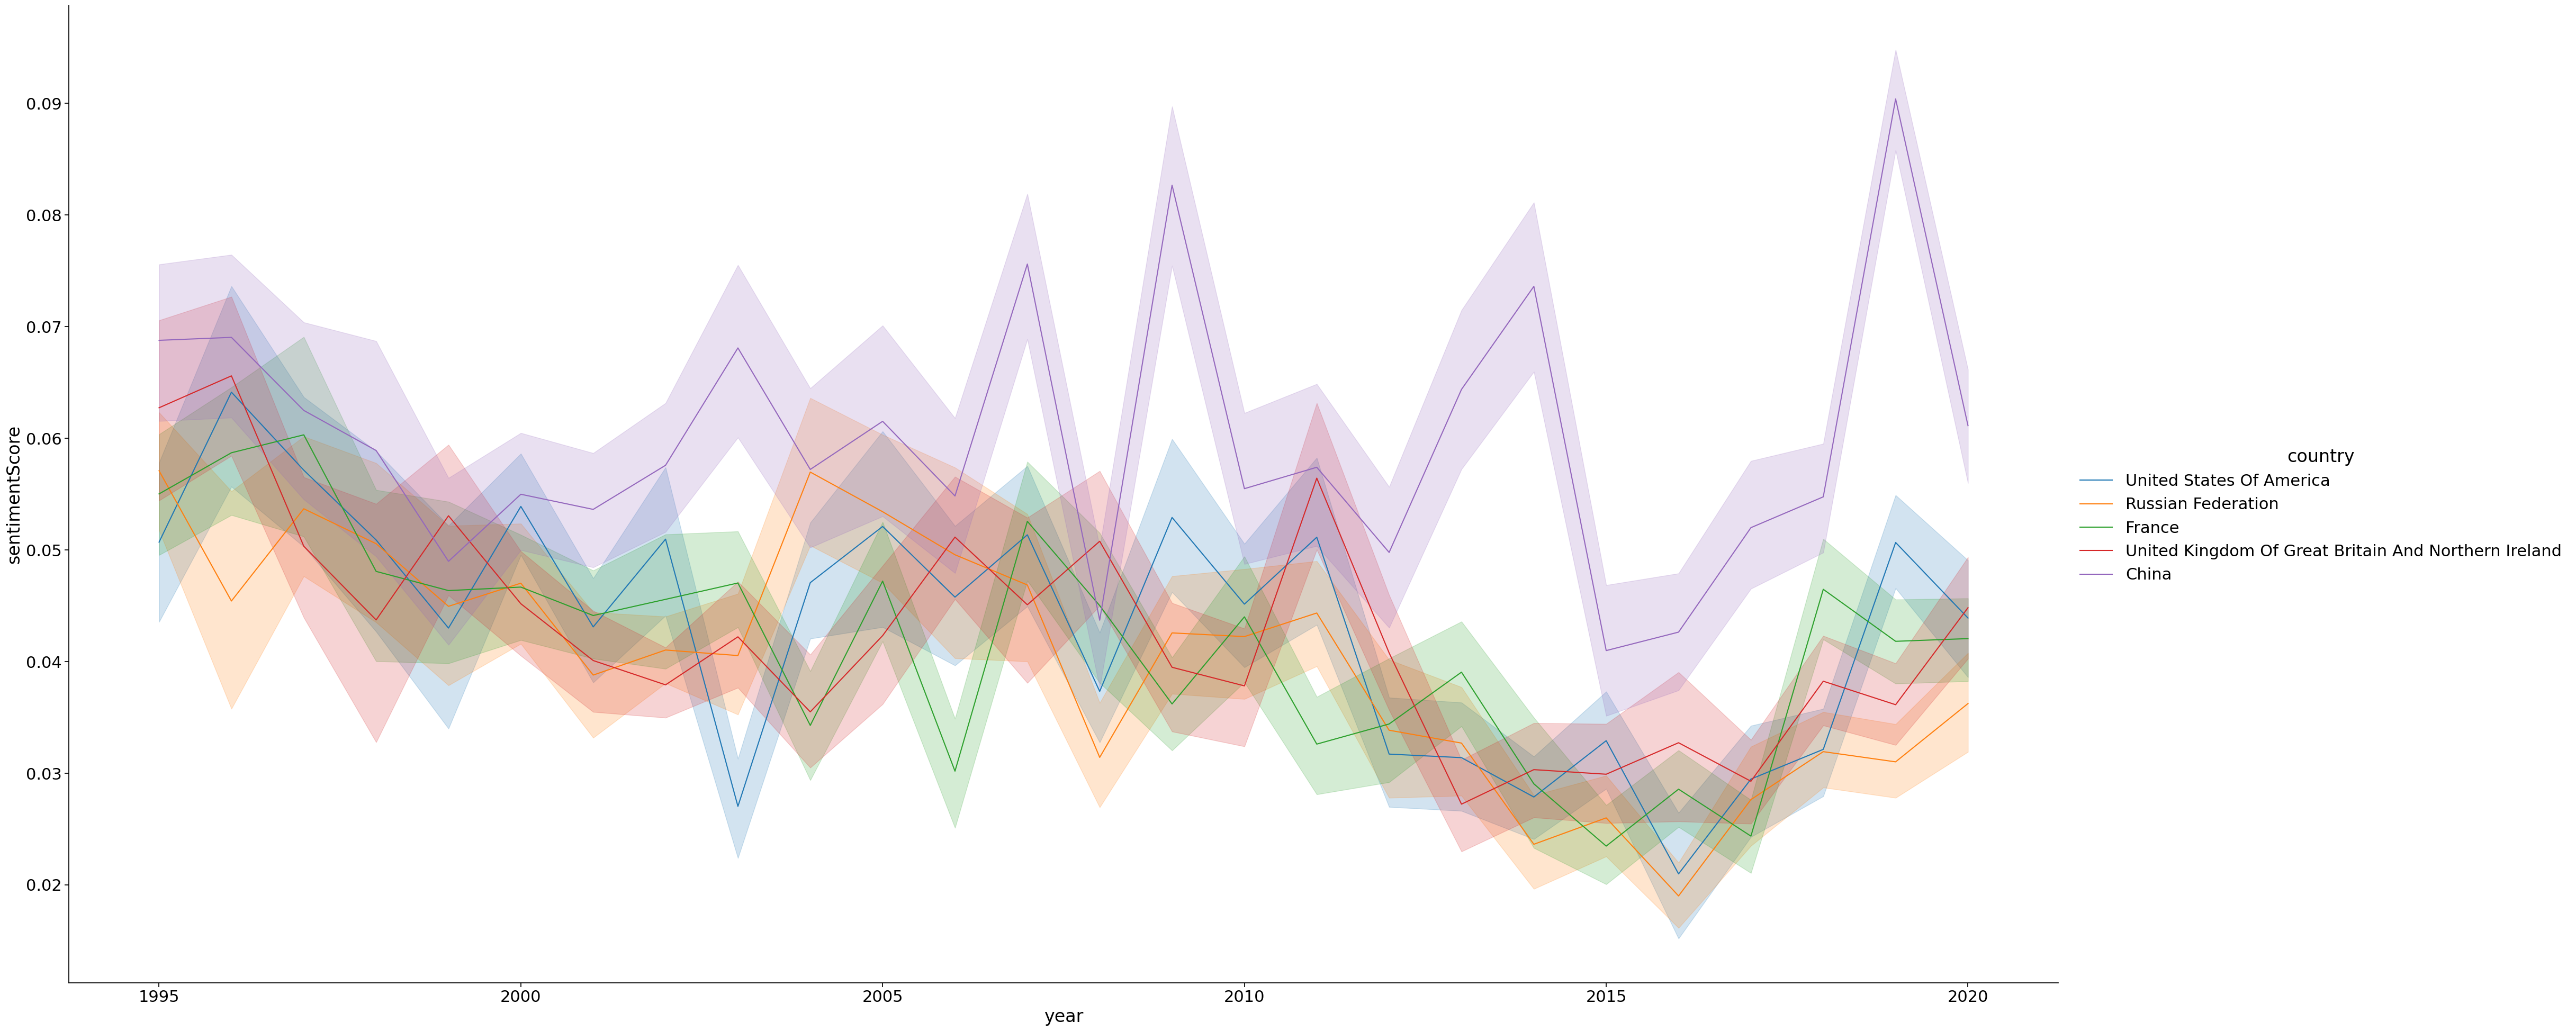

In [64]:
sns_plot = sns.relplot(x="year", y="sentimentScore", hue="country", kind="line", data=p5_df, height=20, aspect=2)